ArrayList可以自动扩容, 但我们知道它是由数组对象(每次都说数组对象是想强调数组是对象并不是基础类型)实现的, 而且数组一旦创建(不是declare), 其size就是fixed. 所以ArrayList扩容, 肯定涉及到了创建更大容量的数组和copy.

那复制是怎么实现的呢? 直接loop循环拷贝吗? 那样好像有点傻, 况且ArrayList那么常用, 这for循环复制也太low了吧(not efficient). 

真相一直藏在源码里, 看看ArrayList里的add方法, 找到了grow函数:


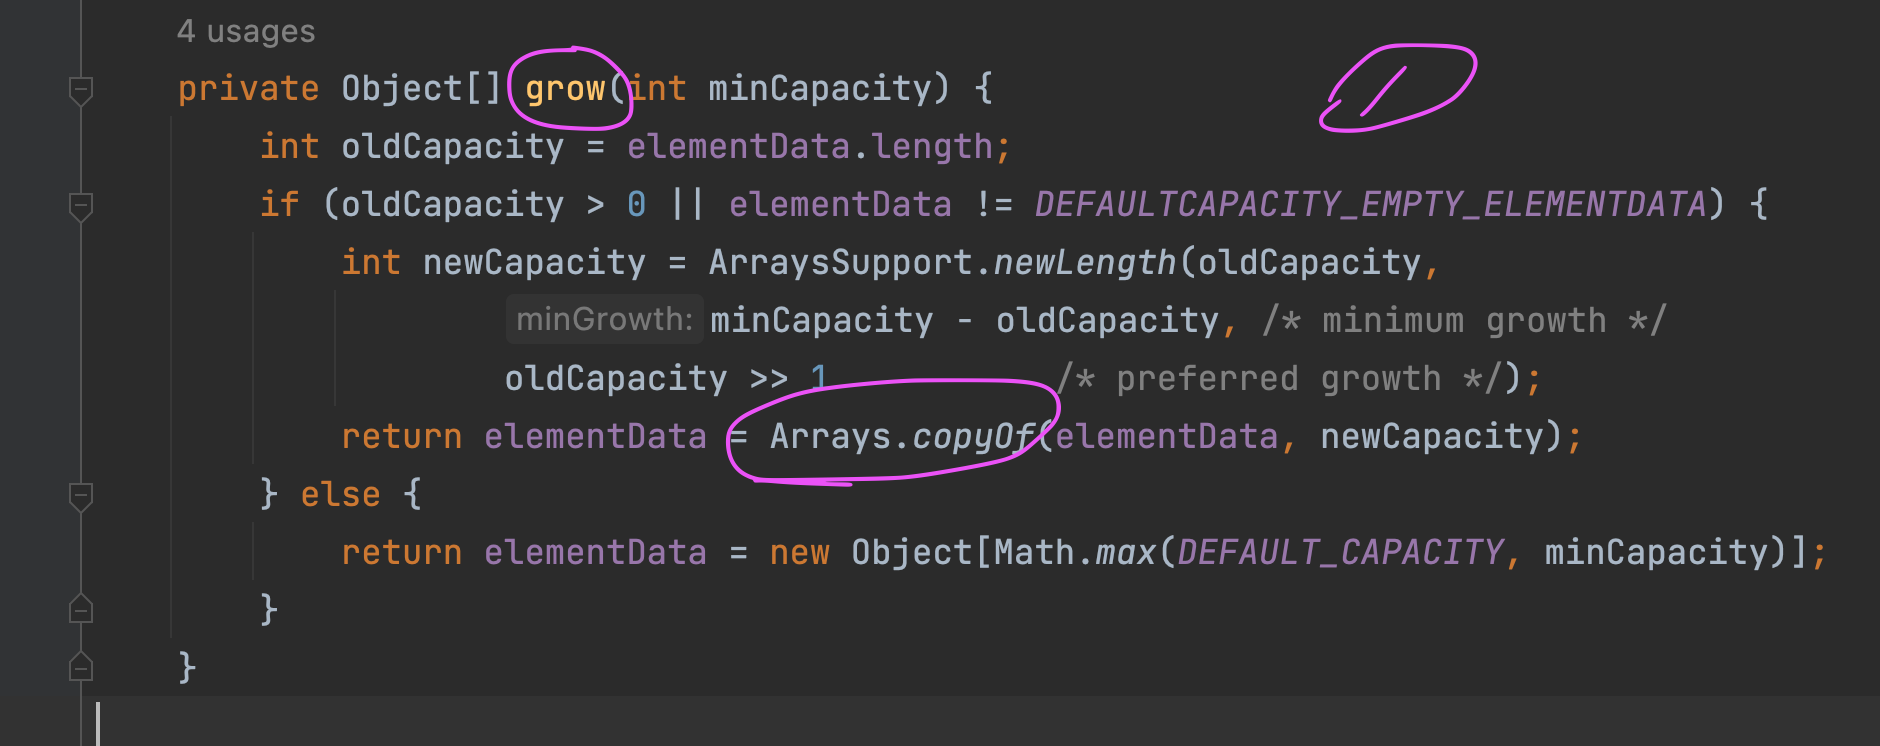

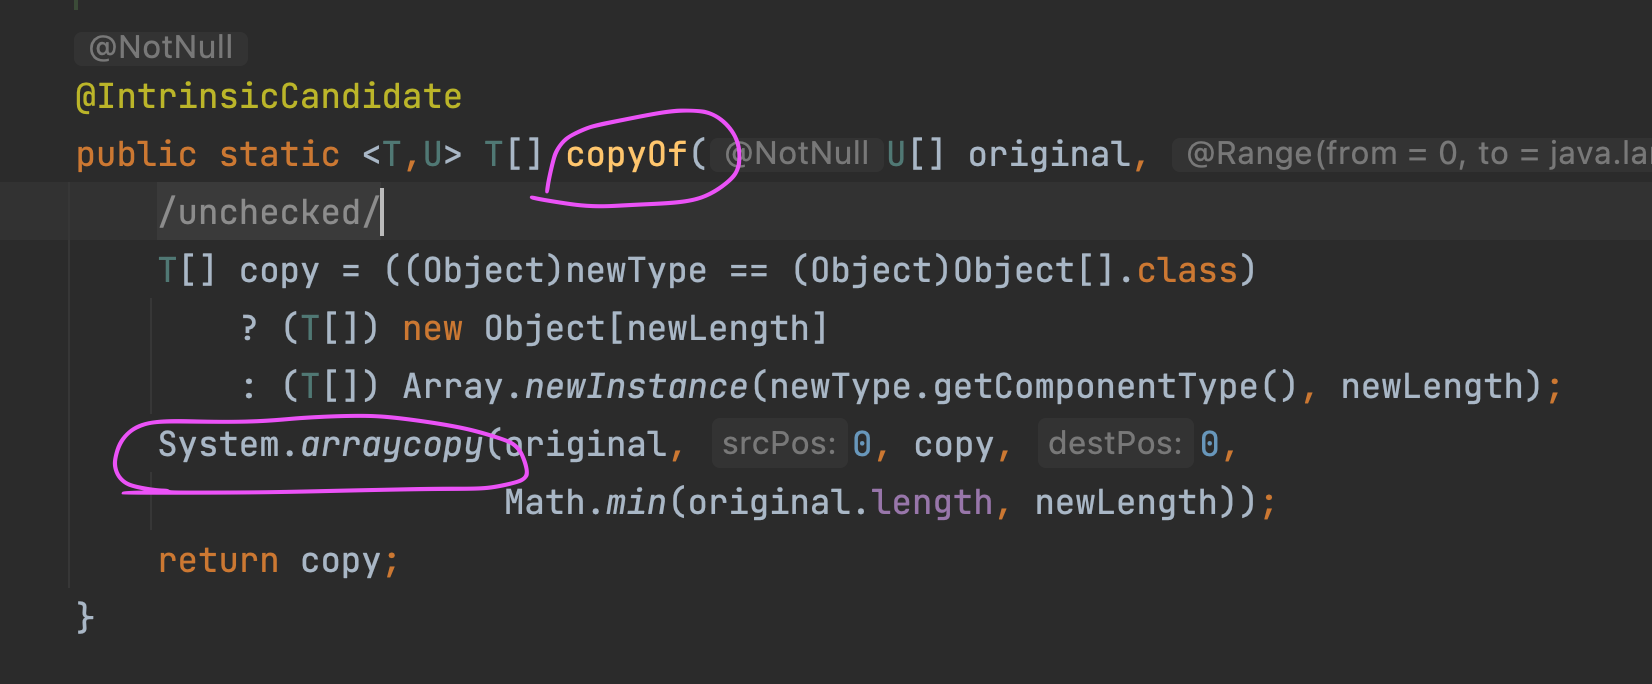

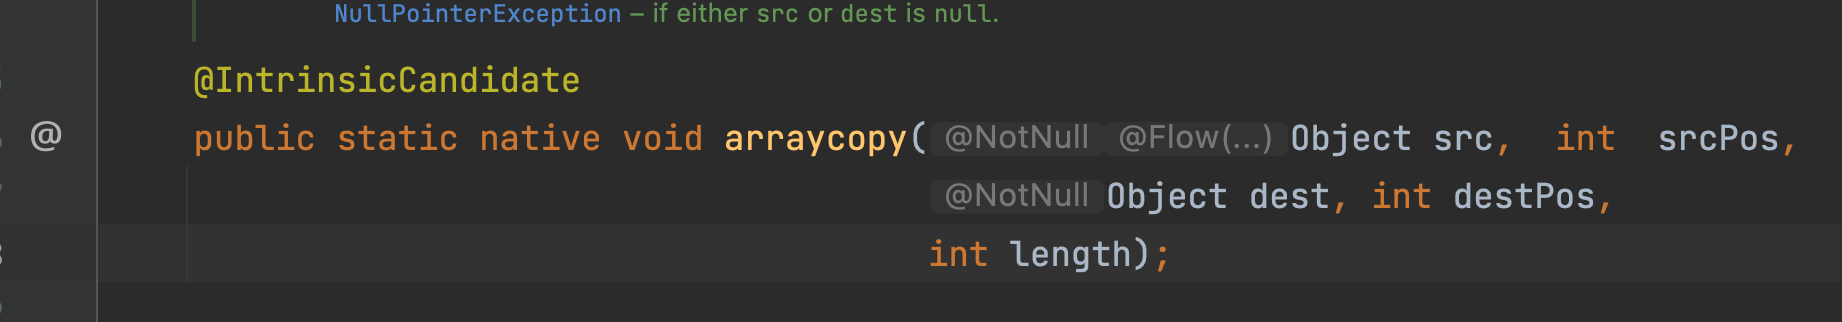

我们可以看到, 这里用到了`native`modifier, 说明arraycopy并不是由Java实现的, 而是其他语言, 大概率是C, 毕竟编译后的C运行起来是很快的与JVM翻译字节码比较, 不止这样, 通过C的库函数`memcpy()`, 本地机器可以直接拷贝一个block内存块, 这效率显然比一个字节一个字的拷贝快的多.况且, C不会进行数组进行边界检查, 这也会节约时间. 以上观点来自一下两个链接:

https://qr.ae/prJ2Lu

https://www.baeldung.com/java-system-arraycopy-arrays-copyof-performance

----

# Java Native Interface (JNI)
---

说了那么多, 这个native method感觉好神奇, 很厉害的样子, 那它究竟是什么呢? 别着急, 先看看JNI. 

As we know, one of the main strengths of Java is its portability – meaning that once we write and compile code, the result of this process is **platform-independent bytecode**.

However, sometimes we do actually need to use code that's **natively-compiled** for a specific architecture.

There could be some reasons for needing to use native code:

1. Accessing platform-specific features or hardware

Java programs can run on different platforms without modification. However, this also means that Java programs cannot access platform-specific features or hardware directly. In such cases, native methods can be used to interface with platform-specific APIs or **device drivers**. For example, a Java program might use a native method to access a camera or a printer that is only available on a specific platform.

2. Performance improvement for a very demanding process

Java provides automatic memory management, garbage collection, and other features that make it easier to write and maintain code. However, these features can come at a performance cost, especially when dealing with large amounts of data or complex algorithms. In such cases, native methods can be used to implement critical parts of the code in a low-level language that can run faster. For example, a Java program might use a native method to perform matrix multiplication or encryption.

3. An existing library that we want to reuse instead of rewriting it in Java

Java programs can use libraries written in other languages, such as C or C++. However, if the library provides a native interface, it might be easier or more efficient to use that instead of wrapping the library in a Java class. For example, a Java program might use a native method to call a C library that provides image processing algorithms.

To achieve this, the JDK introduces a bridge between the bytecode running in our JVM and the native code (usually written in C or C++). The tool is called **Java Native Interface**.

However, it's important to keep in mind that using native methods can also introduce additional complexity and potential issues, such as **compatibility problems** across different platforms and the need to manage memory manually. (From ChatGPT)

---

When using native methods in Java, it's important to follow best practices, such as:

- Ensuring compatibility: Native methods can be platform-specific, which means that they might not work on all platforms or might require different implementations for different platforms. It's important to test the native methods on all target platforms and to provide alternative implementations or fallbacks when necessary.
- Managing memory: Native methods that allocate memory or use pointers need to be carefully managed to avoid memory leaks, buffer overflows, or other memory-related issues. This requires a good understanding of the low-level language and platform-specific memory management techniques.


https://www.baeldung.com/jni

# Native Methods: JVM Meets Compiled Code
----

Normally, when making a native executable program, we can choose to use static or shared libs:

- Static libs – all library binaries will be included as part of our executable during the linking process. Thus, we won't need the libs anymore, but it'll increase the size of our executable file.
- Shared libs – the final executable only has references to the libs, not the code itself. It requires that the environment in which we run our executable has access to all the files of the libs used by our program.

The latter is what makes sense for JNI as we can't mix bytecode and **natively compiled code** into the same binary file. 可以看出native method都是已经编译好的二进制文件. 

Therefore, our shared lib will keep the native code separately within its `.so`/`.dll`/`.dylib` file (depending on which Operating System we're using) instead of being part of our classes.

The native keyword transforms our method into a **sort of abstract method**:

```java
private native void aNativeMethod();
```

With the main difference that **instead of being implemented by another Java class, it will be implemented in a separated native shared library**.

A table with pointers in memory to the implementation of all of our native methods will be constructed so they can be called from our Java code.

# How to Use Native Methods
---

- Java Code – our classes. They will include at least one native method.
- Native Code – the actual logic of our native methods, usually coded in C or C++.
- JNI header file – this header file for C/C++ (include/jni.h into the JDK directory) includes all definitions of JNI elements that we may use into our native programs.
- C/C++ Compiler – we can choose between GCC, Clang, Visual Studio, or any other we like as far as it's able to **generate a native shared library for our platform**.

## Hello World JNI

https://stackoverflow.com/a/29311166/16317008